In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline

In [2]:
'''the import data has no header'''
df = pd.read_csv('IEE520_Train2017Labeled.csv',header=None)
df.columns = df.columns.astype(str)  # in order to call the specific column

## Encode Target class

In [3]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(df['40'])
df['40'] = le.transform(df['40'])


## Preprocess Null data, fill mode by each column

In [4]:
df.replace('?',np.nan,inplace=True)
df = df.astype(float)
df.fillna(df.mode(0).iloc[0],inplace=True).head()  #df.mode will return a dataframe, the first row is the mode and others are NaN

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
0,390.7818,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.226,0.0,1.0,0.0,1.0,0.0,0.0,2.760,1.0,2.0
1,369.0717,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.132,0.0,0.0,0.0,0.0,0.0,1.0,0.825,2.0,1.0
2,354.5983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,6.671,0.0,1.0,1.0,1.0,0.0,0.0,1.791,3.0,1.0
3,499.3323,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.436,0.0,0.0,1.0,1.0,1.0,1.0,4.586,5.0,2.0
4,448.6754,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.125,0.0,1.0,0.0,0.0,1.0,1.0,3.699,2.0,1.0


## Investigate the distribution of the training set

[0,1,2] = ['TYPE0' 'TYPE1' 'TYPE2']
0.0    3694
1.0    1600
2.0     842
Name: 40, dtype: int64


C:\Users\ytsai\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


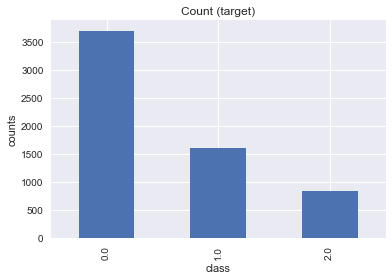

In [5]:
df['40'].value_counts().plot(kind='bar',title='Count (target)')
plt.xlabel('class')
plt.ylabel('counts')
print('[0,1,2] =',le.inverse_transform([0,1,2]))
print(df['40'].value_counts())

## Split train and test before performing oversampling technique
30% data are used for testing
<br>
70% data are used for training

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df.drop('40',1), df['40'], test_size=0.3, random_state=42)

## Store each fold into list for next step(SMOTE)

In [7]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
fold_x = []
fold_y = []
for train_index, validate_index in skf.split(X_train,y_train):
    fold_x.append(X_train.iloc[validate_index])
    fold_y.append(y_train.iloc[validate_index])

## Applied SMOTE on training data(exclude 1 fold for validation) manually
to avoid validation data being affected by SMOTE, I manually applied SMOTE on training set at each fold 
- __Decision Tree__

In [8]:
from imblearn.over_sampling import SMOTE 
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

all_confusion_matrix = np.zeros([3,3])
for left_out in range(5):
    temp_fold_x = fold_x.copy()
    temp_fold_y = fold_y.copy()
    validation_x = temp_fold_x[left_out].copy()
    validation_y = temp_fold_y[left_out].copy()
    del temp_fold_x[left_out]
    del temp_fold_y[left_out]
    upsample_data = SMOTE().fit_sample(pd.concat(temp_fold_x),pd.concat(temp_fold_y))
    train_fold_x = pd.DataFrame(upsample_data[0])
    train_fold_y = upsample_data[1]
    model_tree = DecisionTreeClassifier()
    model_tree.fit(train_fold_x,train_fold_y)
    predict_tree = model_tree.predict(validation_x)
    all_confusion_matrix += confusion_matrix(validation_y,predict_tree)
print(all_confusion_matrix)
print('accuracy_estimation = ', (all_confusion_matrix[0,0]+all_confusion_matrix[1,1]+all_confusion_matrix[2,2])/np.sum(all_confusion_matrix))

[[1764.  587.  248.]
 [ 513.  455.  131.]
 [ 210.  109.  278.]]
accuracy_estimation =  0.5813736903376019


- __SVM__

In [14]:
from imblearn.over_sampling import SMOTE 
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

all_confusion_matrix = np.zeros([3,3])
for left_out in range(5):
    temp_fold_x = fold_x.copy()
    temp_fold_y = fold_y.copy()
    validation_x = temp_fold_x[left_out].copy()
    validation_y = temp_fold_y[left_out].copy()
    del temp_fold_x[left_out]
    del temp_fold_y[left_out]
    upsample_data = SMOTE().fit_sample(pd.concat(temp_fold_x),pd.concat(temp_fold_y))
    train_fold_x = pd.DataFrame(upsample_data[0])
    train_fold_y = upsample_data[1]
    model_SVM = SVC()
    model_SVM.fit(train_fold_x,train_fold_y)
    predict_SVM = model_SVM.predict(validation_x)
    all_confusion_matrix += confusion_matrix(validation_y,predict_SVM)
print(all_confusion_matrix)
print('accuracy_estimation = ', (all_confusion_matrix[0,0]+all_confusion_matrix[1,1]+all_confusion_matrix[2,2])/np.sum(all_confusion_matrix))

[[2337.  163.   99.]
 [ 957.   99.   43.]
 [ 524.   36.   37.]]
accuracy_estimation =  0.5757857974388825


## Tuning Random Forest  (undersampling)
I use OOB error to estimate the model performance.
<br>
To avoid the SMOTE data misleading the error rate, I used undersampling to handle unbalanced_dataset 

[0,1,2] = ['TYPE0' 'TYPE1' 'TYPE2']
2.0    597
1.0    597
0.0    597
dtype: int64


C:\Users\ytsai\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


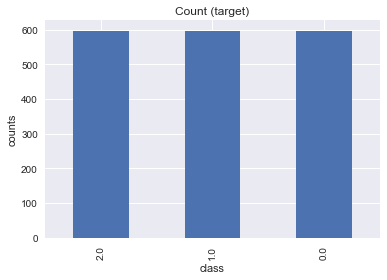

In [27]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
undersample_data = RandomUnderSampler().fit_sample(X_train,y_train)
pd.Series(undersample_data[1]).value_counts().plot(kind='bar',title='Count (target)')
plt.xlabel('class')
plt.ylabel('counts')
print('[0,1,2] =',le.inverse_transform([0,1,2]))
print(pd.Series(undersample_data[1]).value_counts())

In [28]:
from sklearn.grid_search import ParameterGrid
param_grid = {'max_depth':[None,5,10,15,20],'max_features':[3,5,6,7,9],'n_estimators':[100,150,300,450,500]}

best_score = 0
for g in ParameterGrid(param_grid):
    rf = RandomForestClassifier(oob_score=True)
    rf.set_params(**g)
    rf.fit(undersample_data[0],undersample_data[1])
    # save if best
    if rf.oob_score_ > best_score:
        best_score = rf.oob_score_
        best_grid = g

print ("OOB score (accuracy): %0.5f" % best_score) 
print ("Grid:", best_grid)

OOB score (accuracy): 0.66220
Grid: {'max_depth': 15, 'max_features': 6, 'n_estimators': 500}


## Model accuracy comparison:
- __Decision Tree__
- __SVM__
- __Random Forest__

In [37]:
#  Decision Tree
upsampling_train= SMOTE().fit_sample(X_train,y_train)
model_tree = DecisionTreeClassifier()
model_tree.fit(upsampling_train[0],upsampling_train[1])
tree_test_prediction = model_tree.predict(X_test)
print(confusion_matrix(y_test,tree_test_prediction))
print(accuracy_score(y_test,tree_test_prediction))

[[759 233 103]
 [209 232  60]
 [104  36 105]]
0.5953286257468767


In [38]:
#  SVM
upsampling_train= SMOTE().fit_sample(X_train,y_train)
model_SVM = SVC()
model_SVM.fit(upsampling_train[0],upsampling_train[1])
SVM_test_prediction = model_SVM.predict(X_test)
print(confusion_matrix(y_test,SVM_test_prediction))
print(accuracy_score(y_test,SVM_test_prediction))

[[979  71  45]
 [407  67  27]
 [207  18  20]]
0.579033134166214


In [39]:
#  Random Forest
undersample_train = RandomUnderSampler().fit_sample(X_train,y_train)
model_rf = RandomForestClassifier(oob_score=True,max_depth=15, max_features=6, n_estimators= 500)
model_rf.fit(undersample_train[0],undersample_train[1])
rf_test_prediction = model_rf.predict(X_test)
print(confusion_matrix(y_test,rf_test_prediction))
print(accuracy_score(y_test,rf_test_prediction))

[[636 280 179]
 [ 66 359  76]
 [ 36  41 168]]
0.6317218902770234


In [50]:
pd.DataFrame({'tree':[0.595],'SVM':[0.579],'RF':[0.632]},index=['accuracy'])

,RF,SVM,tree
accuracy,0.632,0.579,0.595
